In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pyclesperanto as cle
import seaborn as sns

from mt.constants import CMAP_MASK
from mt.scan import Scan
from mt.utils import get_transpose_order

cle.select_device("RTX")

(OpenCL) NVIDIA GeForce RTX 4070 SUPER (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              565.90
	Device Type:                 GPU
	Compute Units:               56
	Global Memory Size:          12281 MB
	Maximum Object Size:         3070 MB
	Max Clock Frequency:         2505 MHz
	Image Support:               Yes

In [2]:
# specimen = ANALYSIS_SPECIMEN[0]
specimen = "AD64"
path = "../../04_uCT/" + specimen + "/"
scan = Scan(path)
scan.load(logging=True)

Loading pickled Scan object from: ../../06_Results/uCT/AD64/Scan.pkl
Loading images from:  ../../04_uCT/AD64/Slices/
Loaded stack with shape (1781, 175, 2291) and a size of 1.43 GB in 8.89 s.
Loaded _mask from: ../../06_Results/uCT/AD64/_mask.npy
Loaded _particle_mask from: ../../06_Results/uCT/AD64/_particle_mask.npy
Loaded _tesselation from: ../../06_Results/uCT/AD64/_tesselation.npy


In [3]:
scan.calculate_properties()

C:\Users\malte\anaconda3\envs\thesis\Lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


In [4]:
scan.save()

In [5]:
print(scan.analytics.keys())

dict_keys(['mask_analytics', 'particle_statistics', '2d_cell_area', '2d_contact_pct'])


In [195]:
def visualise_region_properties(image, mean_areas, contact_percent):
    sns.set_context("paper")
    sns.set_theme(font="serif", style="dark")
    h, w = image.shape
    fig, axs = plt.subplots(1, 3, figsize=(29, 5))
    fig.subplots_adjust(wspace=0)
    cmap = CMAP_MASK

    def set_ticks_image(ax, h, w, image):
        major_ticks_x = [ii * w / 5 for ii in range(5)]
        minor_ticks_x = [ii * w / 5 + w / 10 for ii in range(5)]
        major_ticks_y = [ii * h / 5 for ii in range(5)]
        minor_ticks_y = [ii * h / 5 + h / 10 for ii in range(5)]
        minor_ticklabels = [str(ii) for ii in range(1, 6)]
        major_ticklabels = [""] * 5

        if image:
            ax.set_xticks(major_ticks_x)
            ax.set_xticks(minor_ticks_x, minor=True)

            ax.set_yticks(major_ticks_y)
            ax.set_yticks(minor_ticks_y, minor=True)
        else:
            ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
            ax.set_xticks([ii for ii in range(5)], minor=True)
            ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
            ax.set_yticks([ii for ii in range(5)], minor=True)

        ax.set_xticklabels(major_ticklabels)
        ax.set_xticklabels(minor_ticklabels, minor=True)
        ax.set_yticklabels(major_ticklabels)
        ax.set_yticklabels(minor_ticklabels, minor=True)
        ax.grid(True)

    axs[0].imshow(image, cmap=cmap)
    # axs[0].set_title("Z slice")
    set_ticks_image(axs[0], h, w, True)
    legend_elements = [matplotlib.patches.Patch(facecolor=[0.878]*3, label="Z slice: ", edgecolor=[0.878]*3),
                       matplotlib.patches.Patch(facecolor=cmap(0), label="Air"),
                       matplotlib.patches.Patch(facecolor=cmap(1), label="PMMA"),
                       matplotlib.patches.Patch(facecolor=cmap(2), label="Al")]
    # box = axs[0].get_position()
    # axs[0].set_position([box.x0, box.y0, box.width, box.height * 1])

    axs[0].legend(handles=legend_elements,
                  loc='upper center',
                  bbox_to_anchor=(0.5, 1.1),
                  ncols=4,
                  facecolor=[0.878]*3,
                  framealpha=1)

    im = axs[1].imshow(mean_areas * 1e6, cmap="plasma")
    axs[1].set_title("Mean area of cells in region in $\mathrm{\mu m^2}$")
    set_ticks_image(axs[1], h, w, False)
    fig.colorbar(im, ax=axs[1])
    axs[1].set_aspect(h / w)

    im = axs[2].imshow(contact_percent * 100, cmap="plasma")
    axs[2].set_title("PMMA-Al contact percentage")
    set_ticks_image(axs[2], h, w, False)
    fig.colorbar(im, ax=axs[2])
    axs[2].set_aspect(h / w)
    plt.savefig("region_properties.png", dpi=300, bbox_inches="tight", pad_inches=0.02)

In [7]:
scan.show("z")

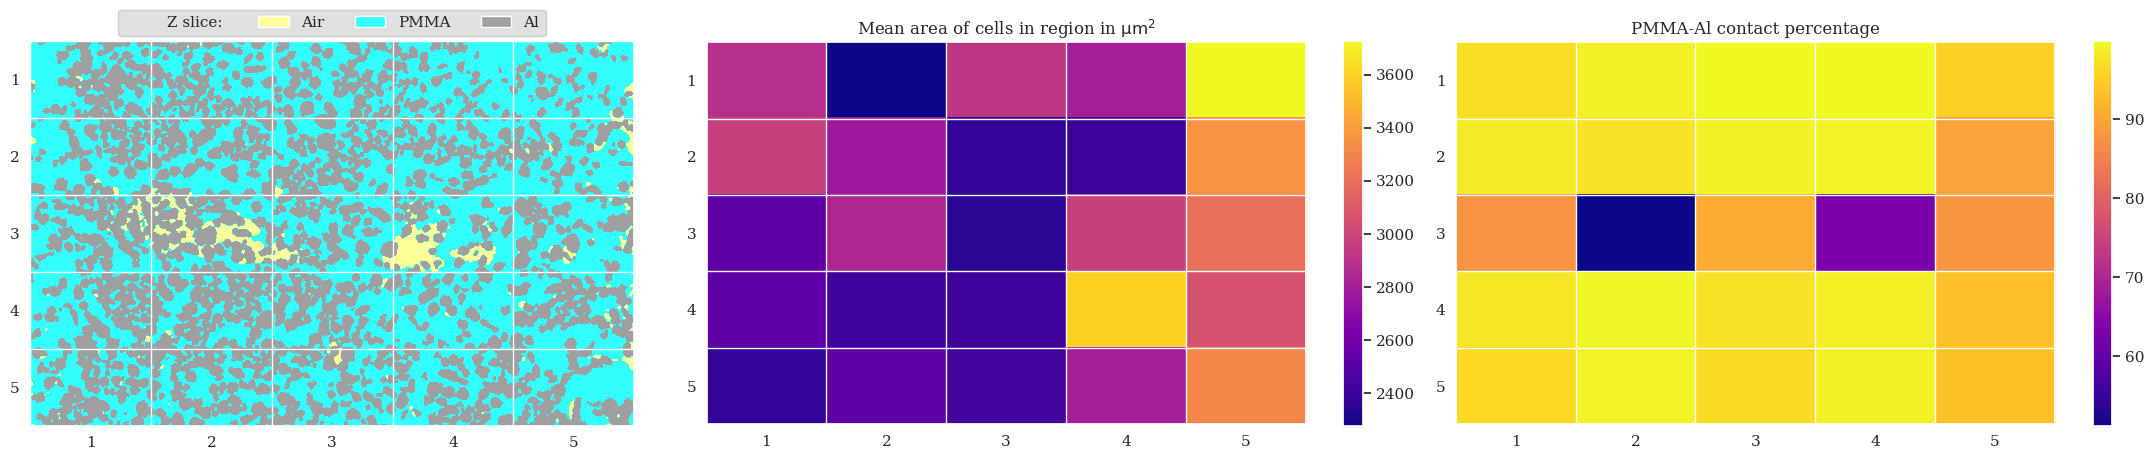

In [196]:
areas, contact = scan.analytics["2d_cell_area"], scan.analytics["2d_contact_pct"]
stack = np.transpose(scan.get_mask(), get_transpose_order(scan.get_stack(), "z"))
image = stack[len(stack) // 2]
visualise_region_properties(image, areas, contact)

Text(0, 0.5, 'Polymer contact percentage')

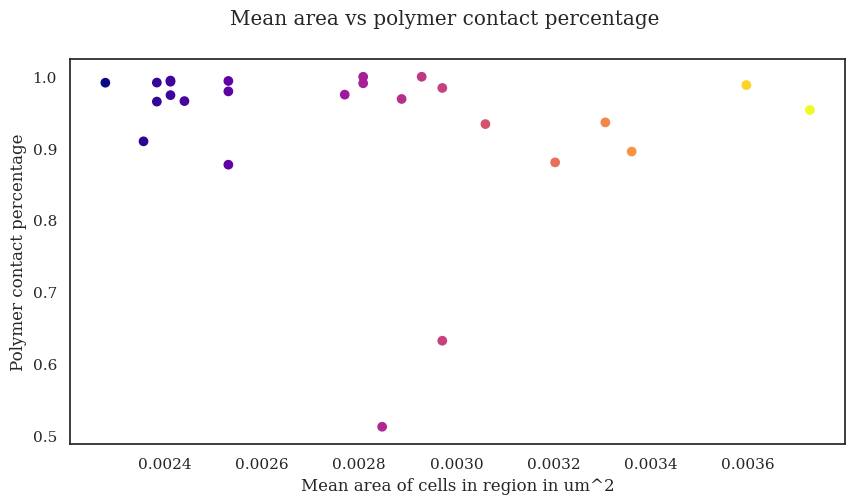

In [9]:
# areas, contact = np.sort(areas.flatten()), np.sort(contact.flatten())
fig, axs = plt.subplots(1, figsize=(10, 5), sharex=True, sharey=True)
axs.scatter(areas.ravel(), contact.ravel(), c=areas.ravel(), cmap="plasma")
plt.suptitle("Mean area vs polymer contact percentage")
plt.xlabel("Mean area of cells in region in um^2")
plt.ylabel("Polymer contact percentage")